#Objective
<h3> Currently, we are facing the problem of shortcomings of predicting the close of next day with respect to the previous close values. However, in this notebook, our aim is to predict the close with taking into consideration the average sentiment of StockTwits and Close simultaneously.
</h3>


<h4> Keep in mind that we are using in this notebook our scraped dataset for sentiment analysis feature for each tweet</h4>

**Briefly, you can find in the notebook an implementing for**: 
1. Predicting the tomorrow's Close using LSTM.
2. A greedy algorithm which gives advice to the investor when he/she buy or sell.

 

# Installing Important Packages

In [ ]:
#Installs
!pip install backtrader
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

# Importing the Data

In [ ]:
import math 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from keras.models import Sequential
from datetime import date, timedelta
from re import X

#BackTrader for Trading Algorithm

import backtrader as bt
import backtrader.indicators as btind
import datetime
import os.path
import sys



In [ ]:

def daterange(start_date, end_date):
      for n in range(int((end_date - start_date).days)):
          yield start_date + timedelta(n)  
 

# Training Class
<h4> Class For PreProcessing the data and training the Model using LSTM </h4>

In [ ]:

class trainingTheModel(): 

    def __init__(self, path, stockName):
        self.path = path 
        self.df = pd.read_csv(path) 
        self.stockName = stockName


    def concatenate(self, startDate, endDate):
        df = self.df
        StockName = self.stockName

        sentimentDF = df[df['symbol'] ==StockName]
        sentDF = df.groupby(['Date']).mean()


        stock_DF = pdr.get_data_yahoo(StockName,  start = startDate , end = endDate)
        df_temp = stock_DF['Close']
        sentDF.drop(columns = ['user', 'message_id'] , inplace=True)
        
        sentDF = sentDF[sentDF.index>= startDate]
        sentDF = sentDF[sentDF.index <= endDate]
        
        #Getting Stock Information  
        
        df_temp = pd.DataFrame()
        df_temp['Close'] = stock_DF['Close']
        df = df_temp.copy()
        df['Date'] = df.index.values
        sentDF['Date'] = sentDF.index.values
        df.index.name = None
        sentDF.index.name = None
        sentDF['Date']= pd.to_datetime(sentDF['Date'])
        df_cd = pd.merge(df,sentDF, how='inner', on = 'Date')
        df = df_cd.set_index('Date')
        self.df = df 
        self.df_temp = df_temp
        # print("HERE", self.df.columns)

        return df, df_temp


    def plotCloseVsDate(self):
        
        df,_ = self.concatenate("2012-01-03", '2019-12-31')

        plt.figure(figsize = (16,8))
        plt.title('CLose Price History')
        plt.plot(df['Close'])
        plt.xlabel('Date' , fontsize = 16)
        plt.ylabel('Close Price USD' , fontsize = 16)
        plt.show()

    def splittingData(self):

        df,df_temp = self.df, self.df_temp
        data = df_temp
        dataset = data.values 
        self.training_data_len = math.ceil(len(dataset) * 0.8)
        self.scaler = MinMaxScaler(feature_range = (0,1))
        scaled_data = self.scaler.fit_transform(dataset)
        df['Close'] = scaled_data
        self.scaled_data = np.array(df)
        train_data = self.scaled_data[: self.training_data_len,] 

        # print(train_data.shape)
        self.x_train = []
        self.y_train = []

        for i in range(60, len(train_data)):
            self.x_train.append(train_data[i-60: i ,])
            self.y_train.append(train_data[i,0])
            # if(i <= 60): 
            #     print(self.x_train)
            #     print(self.y_train)
        self.x_train, self.y_train = np.array(self.x_train), np.array(self.y_train)
        self.x_train = np.reshape(self.x_train, (self.x_train.shape[0], self.x_train.shape[1], 2))

    def modelArchitecture(self,epochs = 1 , batch_size = 1):
        self.model = Sequential()
        self.model.add(LSTM(50, return_sequences= True, input_shape = (self.x_train.shape[1],2)))
        self.model.add(LSTM(50,return_sequences = False))
        self.model.add(Dense(25))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss = 'mean_squared_error')
        self.model.fit(self.x_train,self.y_train,batch_size = batch_size, epochs = epochs)
    
    def testModel(self):
        df = np.array(self.df)
        test_data = df[self.training_data_len - 60 : ,]

        self.x_test = []
        dataset = self.df_temp.values
        self.y_test = dataset[self.training_data_len:]

        for i in range(60, len(test_data)):
            self.x_test.append(test_data[i-60:i])
        self.x_test = np.array(self.x_test)
        self.x_test = np.reshape(self.x_test, (self.x_test.shape[0], self.x_test.shape[1],2))

        # print(self.x_test)
        #predicting the Model 
        self.predictions = self.model.predict(self.x_test)
        self.predictions = self.scaler.inverse_transform(self.predictions)
        #Test the accuracy 
        rmse = np.sqrt(np.mean(self.predictions - self.y_test)**2)
        print("ERROR rmse = ", rmse)
    
    def visualizeTheTest(self):

        data = self.df_temp
        train = data[:self.training_data_len]
        valid = data[self.training_data_len:]
        # print(valid.shape)
        # print(self.predictions.shape)
        valid["predictions"] = self.predictions
        plt.figure(figsize = (16,8))
        plt.title("Model")
        plt.xlabel("Date", fontsize=18)
        plt.ylabel("Close Price USD ", fontsize=18)
        plt.plot(train['Close'])
        plt.plot(valid[['Close', 'predictions']])
        plt.legend(['Train', 'Val', 'predictions'], loc='lower right')
        plt.show()


    def simulateFuture60Days(self):
        predictedDF = pd.DataFrame(columns = ["predicted Close", "Date"])
        start_date = date(2019, 1, 1)
        end_date = date(2019, 12, 31)
        for single_date in daterange(start_date, end_date):
            day_date = single_date.strftime("%Y-%m-%d")

            sentiment_quote = self.df[self.df.index < day_date]
            new_sentiment = sentiment_quote

            last_60_days_sentiment = new_sentiment[-60:]
            X_test=[]

            X_test.append(last_60_days_sentiment)
            
            X_test=np.array(X_test)
            
            X_test= np.reshape(X_test,(X_test.shape[0],X_test.shape[1],2))
            
            pred=self.model.predict(X_test)
            
            pred=self.scaler.inverse_transform(pred)
            value = pred.item()
            df2 = {"predicted Close" : value , "Date": day_date}
            predictedDF = predictedDF.append(df2, ignore_index = True)

            temp_df2 = self.df_temp.copy()
            temp_df2['Date'] = temp_df2.index
            temp_df2.index.name = None
            temp_df2['Date']= pd.to_datetime(temp_df2['Date'])
            predictedDF['Date']= pd.to_datetime(predictedDF['Date'])

            df_predicted = pd.merge(temp_df2,predictedDF, how='inner', on = 'Date')
            df_predicted
            self.df_predicted = df_predicted.set_index('Date')
    
    def visualizeTestVsActual(self):

        plt.figure(figsize = (16,8))
        plt.title("Model")
        plt.xlabel("Date", fontsize=18)
        plt.ylabel("Close Price USD ", fontsize=18)
        plt.plot(self.df_predicted['Close'])
        plt.plot(self.df_predicted[['predicted Close']])
        plt.legend(['Close', 'predicted Close'], loc='lower right')
        plt.show()
        self.df_predicted.rename(columns = {'Close':'close', 'predicted Close':'open'}, inplace = True)
        return self.df_predicted

    

#Portofolio
<h4> A greedy algorithm (Portofolio) for the invester when he/she can buy or sell </h4>

In [ ]:
class Strat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # print(self.datas[0])
        self.predicted = self.datas[0].open
        # print(self.predicted[0])
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None  
        self.date = self.data.datetime

        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                # self.buycomm = order.executed.comm
                self.buycomm = 0
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):
        # log closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        date = bt.num2date(self.date[0]).date()
        # prev_sentiment = self.sentiment
        # if date in date_sentiment:
        #     self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return
        # print(self.sentiment)

       
        # buy if current close more than sma AND sentiment increased by >= 0.5
        # if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
        if abs(self.predicted[0] - self.dataclose[-1]) > 0.005*self.dataclose[-1]:
                # print("H", self.predicted[0], " ", self.dataclose[-1])
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()     
        else: 
              self.log('SELL CREATE, %.2f' % self.dataclose[0])
              self.order = self.sell()
   

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)

In [ ]:
def portofolio(df_predicted):
    cerebro = bt.Cerebro()
    
    # Strategy
    cerebro.addstrategy(Strat)

    # Data Feed

    data = bt.feeds.PandasData(dataname=df_predicted)

    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    cerebro.broker.setcommission(commission=0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Sample Stocks (FAANG)

In [ ]:
path = '/content/drive/MyDrive/Application on Sentiment Analysis submission/Dataset/SentimentDataset_NotScraped(From Github)/Combined_FAANG_binary_previous.csv'


## Google (GOOGL)

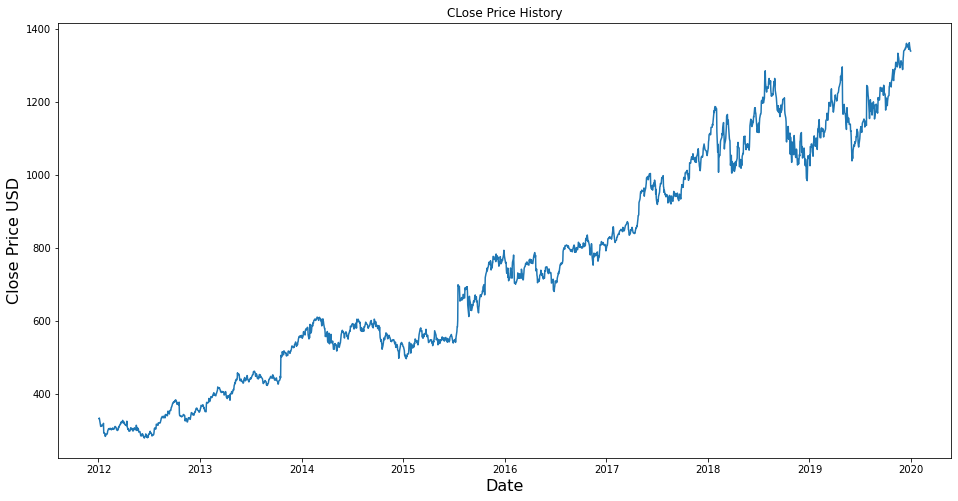

1550/1550 [==============================] - 74s 42ms/step - loss: 0.0015
ERROR rmse =  72.17893807330535


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


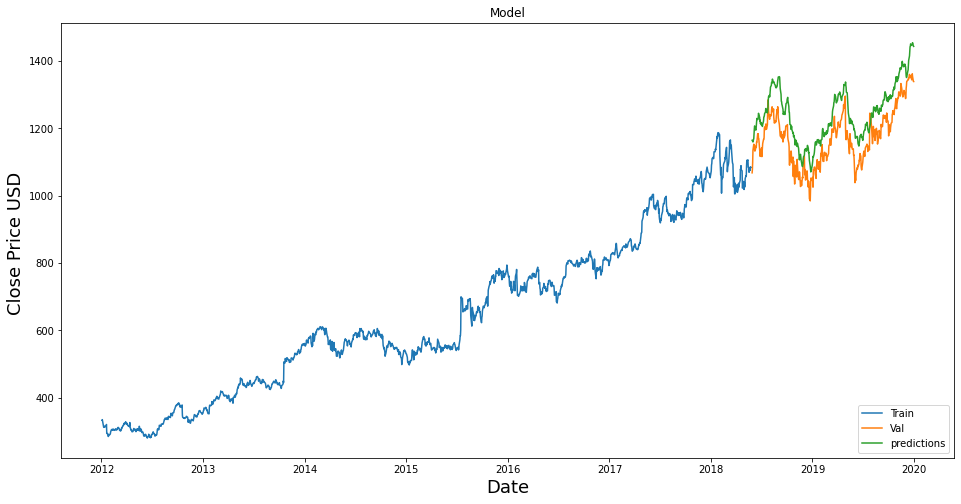

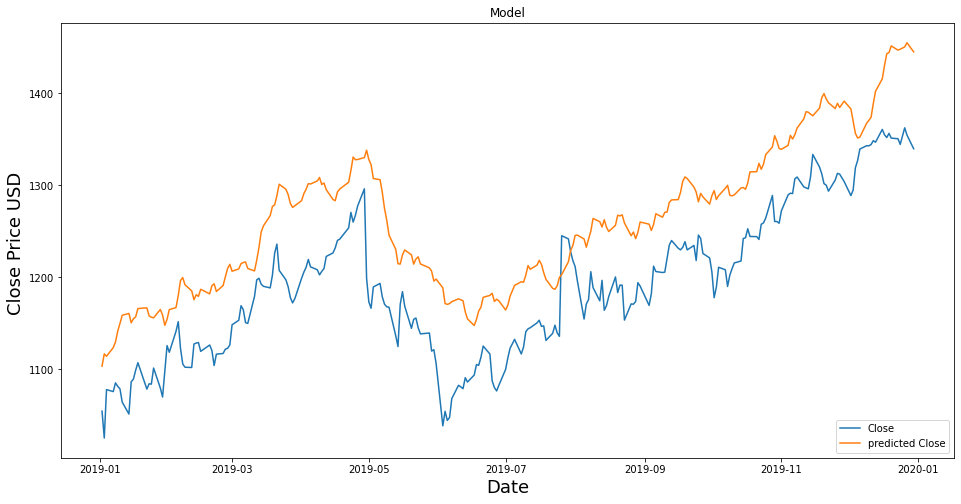

Starting Portfolio Value: 100000.00
2019-01-02, Close, 1054.68
2019-01-02, BUY CREATE, 1054.68
2019-01-03, BUY EXECUTED, Price: 1116.90, Cost: 11168.99, Comm 0.00
2019-01-03, Close, 1025.47
2019-01-03, BUY CREATE, 1025.47
2019-01-04, BUY EXECUTED, Price: 1114.23, Cost: 11142.34, Comm 0.00
2019-01-04, Close, 1078.07
2019-01-04, BUY CREATE, 1078.07
2019-01-07, BUY EXECUTED, Price: 1123.65, Cost: 11236.48, Comm 0.00
2019-01-07, Close, 1075.92
2019-01-07, BUY CREATE, 1075.92
2019-01-08, BUY EXECUTED, Price: 1129.79, Cost: 11297.91, Comm 0.00
2019-01-08, Close, 1085.37
2019-01-08, BUY CREATE, 1085.37
2019-01-09, BUY EXECUTED, Price: 1141.57, Cost: 11415.73, Comm 0.00
2019-01-09, Close, 1081.65
2019-01-09, BUY CREATE, 1081.65
2019-01-10, BUY EXECUTED, Price: 1149.91, Cost: 11499.06, Comm 0.00
2019-01-10, Close, 1078.83
2019-01-10, BUY CREATE, 1078.83
2019-01-11, BUY EXECUTED, Price: 1158.79, Cost: 11587.90, Comm 0.00
2019-01-11, Close, 1064.47
2019-01-11, BUY CREATE, 1064.47
2019-01-14, BUY 

In [ ]:
stockName = 'GOOGL'
google = trainingTheModel(path, stockName)
google.plotCloseVsDate()
google.splittingData()
google.modelArchitecture()
google.testModel()
google.visualizeTheTest()
predicted_df = google.simulateFuture60Days()
google.visualizeTestVsActual()
portofolio(google.df_predicted)

## Facebook (FB)

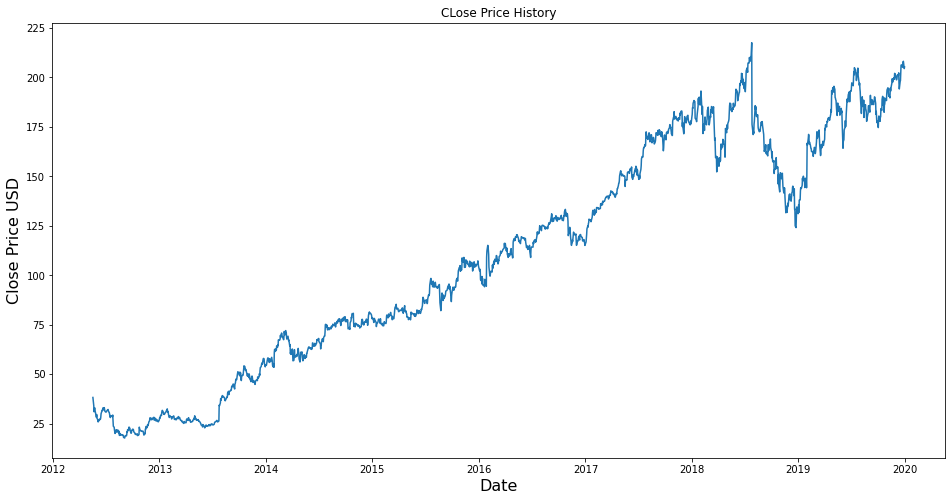

1474/1474 [==============================] - 48s 31ms/step - loss: 0.0014
ERROR rmse =  8.211559684096056


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


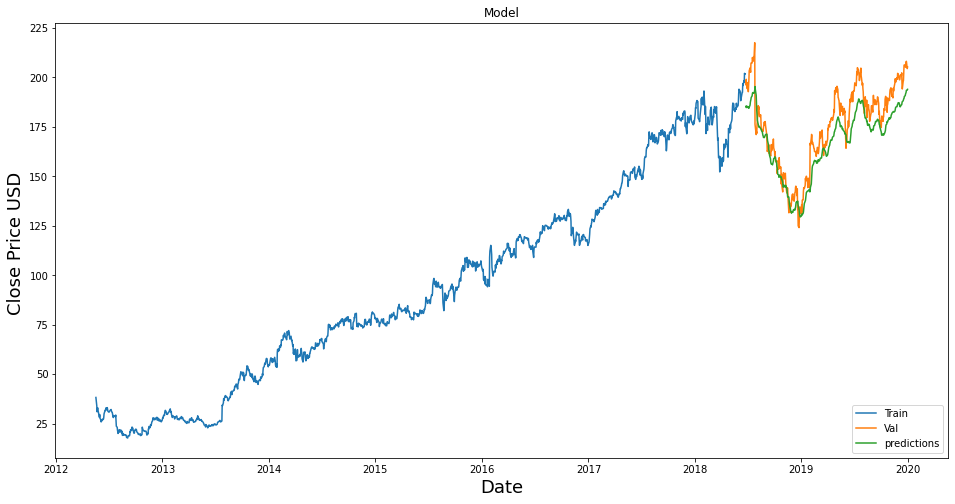

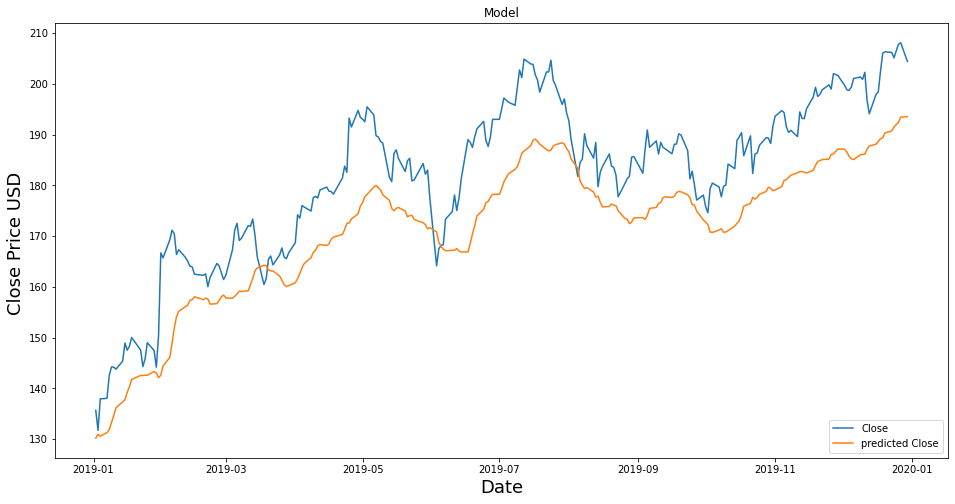

Starting Portfolio Value: 100000.00
2019-01-02, Close, 135.68
2019-01-02, BUY CREATE, 135.68
2019-01-03, BUY EXECUTED, Price: 130.96, Cost: 1309.58, Comm 0.00
2019-01-03, Close, 131.74
2019-01-03, BUY CREATE, 131.74
2019-01-04, BUY EXECUTED, Price: 130.60, Cost: 1306.04, Comm 0.00
2019-01-04, Close, 137.95
2019-01-04, BUY CREATE, 137.95
2019-01-07, BUY EXECUTED, Price: 131.30, Cost: 1312.97, Comm 0.00
2019-01-07, Close, 138.05
2019-01-07, BUY CREATE, 138.05
2019-01-08, BUY EXECUTED, Price: 131.91, Cost: 1319.10, Comm 0.00
2019-01-08, Close, 142.53
2019-01-08, BUY CREATE, 142.53
2019-01-09, BUY EXECUTED, Price: 133.25, Cost: 1332.48, Comm 0.00
2019-01-09, Close, 144.23
2019-01-09, BUY CREATE, 144.23
2019-01-10, BUY EXECUTED, Price: 134.63, Cost: 1346.33, Comm 0.00
2019-01-10, Close, 144.20
2019-01-10, BUY CREATE, 144.20
2019-01-11, BUY EXECUTED, Price: 136.19, Cost: 1361.90, Comm 0.00
2019-01-11, Close, 143.80
2019-01-11, BUY CREATE, 143.80
2019-01-14, BUY EXECUTED, Price: 137.35, Cost:

In [ ]:
stockName = 'FB'
facebook = trainingTheModel(path, stockName)
facebook.plotCloseVsDate()
facebook.splittingData()
facebook.modelArchitecture()
facebook.testModel()
facebook.visualizeTheTest()
predicted_df = facebook.simulateFuture60Days()
facebook.visualizeTestVsActual()
portofolio(facebook.df_predicted)

## Amazon (AMZN)

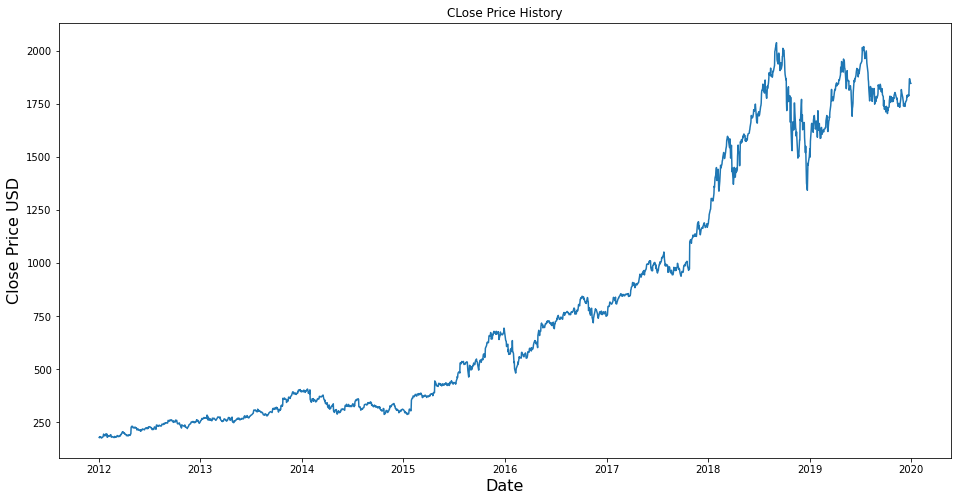

1550/1550 [==============================] - 49s 30ms/step - loss: 9.5288e-04
ERROR rmse =  103.24403950705457


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


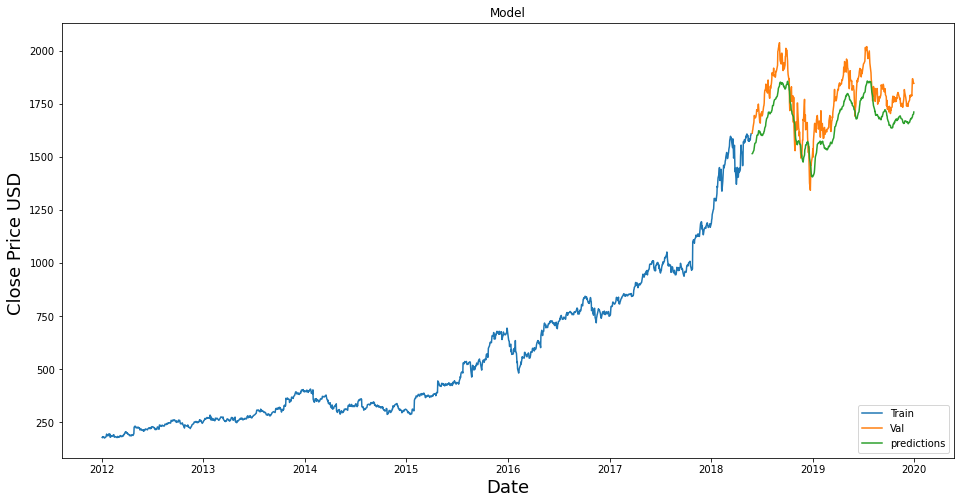

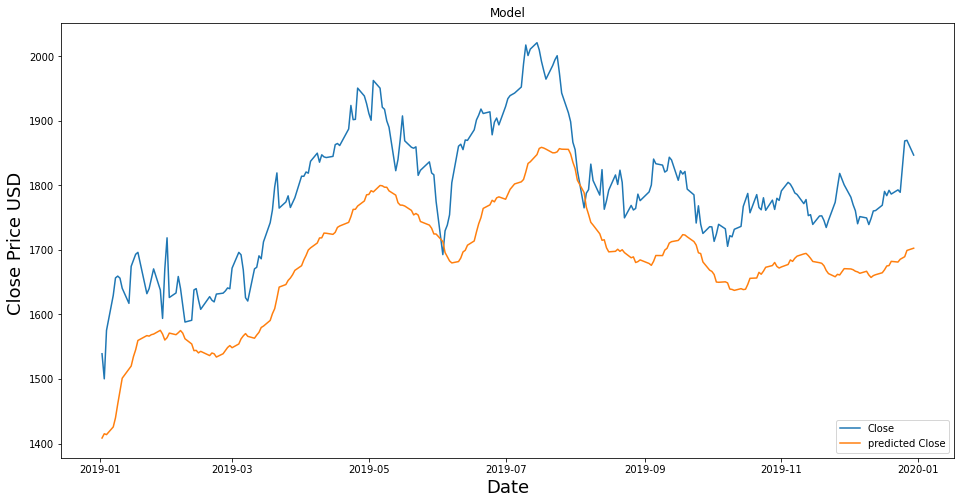

Starting Portfolio Value: 100000.00
2019-01-02, Close, 1539.13
2019-01-02, BUY CREATE, 1539.13
2019-01-03, BUY EXECUTED, Price: 1415.19, Cost: 14151.92, Comm 0.00
2019-01-03, Close, 1500.28
2019-01-03, BUY CREATE, 1500.28
2019-01-04, BUY EXECUTED, Price: 1413.87, Cost: 14138.72, Comm 0.00
2019-01-04, Close, 1575.39
2019-01-04, BUY CREATE, 1575.39
2019-01-07, BUY EXECUTED, Price: 1425.76, Cost: 14257.61, Comm 0.00
2019-01-07, Close, 1629.51
2019-01-07, BUY CREATE, 1629.51
2019-01-08, BUY EXECUTED, Price: 1439.81, Cost: 14398.13, Comm 0.00
2019-01-08, Close, 1656.58
2019-01-08, BUY CREATE, 1656.58
2019-01-09, BUY EXECUTED, Price: 1461.21, Cost: 14612.06, Comm 0.00
2019-01-09, Close, 1659.42
2019-01-09, BUY CREATE, 1659.42
2019-01-10, BUY EXECUTED, Price: 1481.09, Cost: 14810.92, Comm 0.00
2019-01-10, Close, 1656.22
2019-01-10, BUY CREATE, 1656.22
2019-01-11, Order Canceled/Margin/Rejected
2019-01-11, Close, 1640.56
2019-01-11, BUY CREATE, 1640.56
2019-01-14, Order Canceled/Margin/Rejecte

In [ ]:
stockName = 'AMZN'
amazon = trainingTheModel(path, stockName)
amazon.plotCloseVsDate()
amazon.splittingData()
amazon.modelArchitecture()
amazon.testModel()
amazon.visualizeTheTest()
predicted_df = amazon.simulateFuture60Days()
amazon.visualizeTestVsActual()
portofolio(amazon.df_predicted)

## Apple (AAPL)

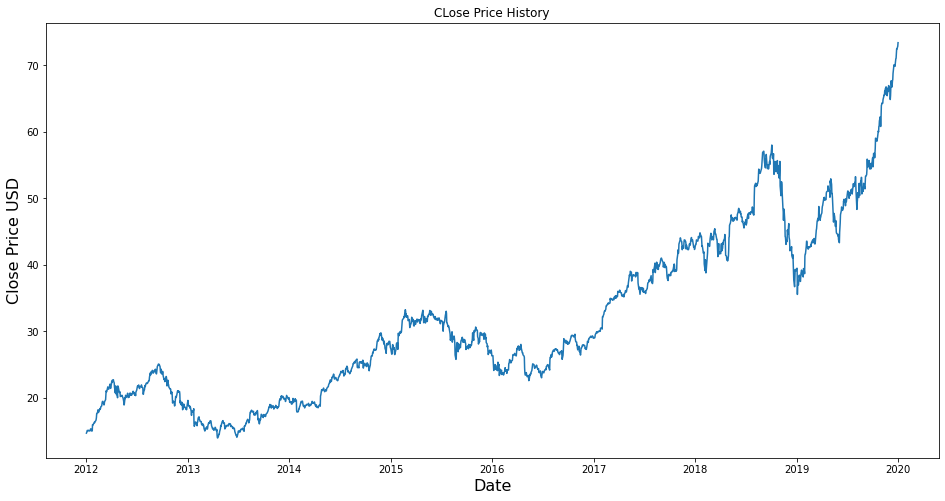

1550/1550 [==============================] - 50s 30ms/step - loss: 7.7893e-04
ERROR rmse =  5.333311137868397


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


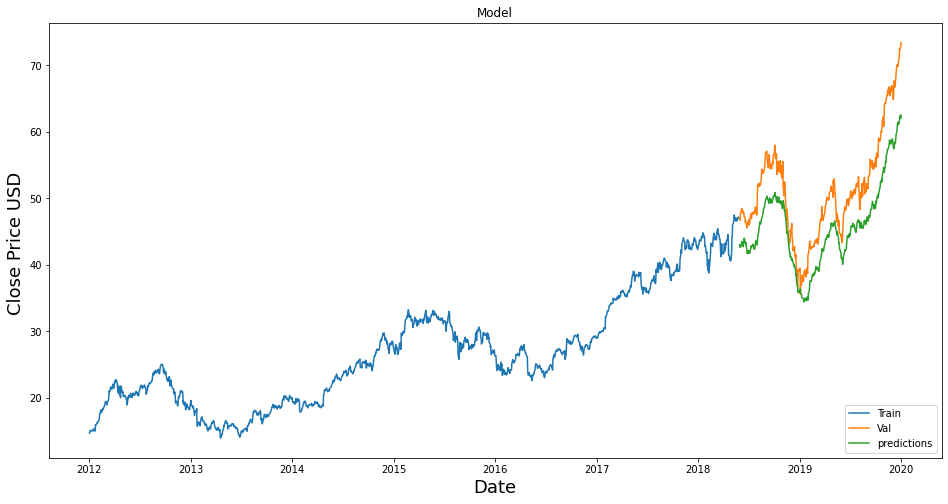

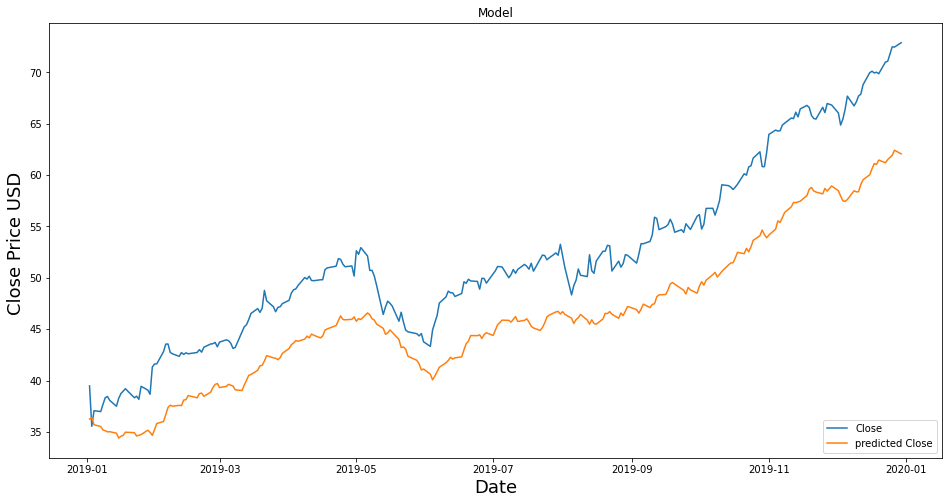

Starting Portfolio Value: 100000.00
2019-01-02, Close, 39.48
2019-01-02, BUY CREATE, 39.48
2019-01-03, BUY EXECUTED, Price: 36.37, Cost: 363.69, Comm 0.00
2019-01-03, Close, 35.55
2019-01-03, BUY CREATE, 35.55
2019-01-04, BUY EXECUTED, Price: 35.70, Cost: 357.02, Comm 0.00
2019-01-04, Close, 37.06
2019-01-04, SELL CREATE, 37.06
2019-01-07, SELL EXECUTED, Price: 35.53, Cost: 360.35, Comm 0.00
2019-01-07, Close, 36.98
2019-01-07, BUY CREATE, 36.98
2019-01-08, BUY EXECUTED, Price: 35.19, Cost: 351.88, Comm 0.00
2019-01-08, Close, 37.69
2019-01-08, BUY CREATE, 37.69
2019-01-09, BUY EXECUTED, Price: 35.12, Cost: 351.23, Comm 0.00
2019-01-09, Close, 38.33
2019-01-09, BUY CREATE, 38.33
2019-01-10, BUY EXECUTED, Price: 35.01, Cost: 350.06, Comm 0.00
2019-01-10, Close, 38.45
2019-01-10, BUY CREATE, 38.45
2019-01-11, BUY EXECUTED, Price: 35.02, Cost: 350.23, Comm 0.00
2019-01-11, Close, 38.07
2019-01-11, BUY CREATE, 38.07
2019-01-14, BUY EXECUTED, Price: 34.88, Cost: 348.82, Comm 0.00
2019-01-14

In [ ]:
stockName = 'AAPL'
apple = trainingTheModel(path, stockName)
apple.plotCloseVsDate()
apple.splittingData()
apple.modelArchitecture()
apple.testModel()
apple.visualizeTheTest()
predicted_df = apple.simulateFuture60Days()
apple.visualizeTestVsActual()
portofolio(apple.df_predicted)

## Netflix (NFLX)

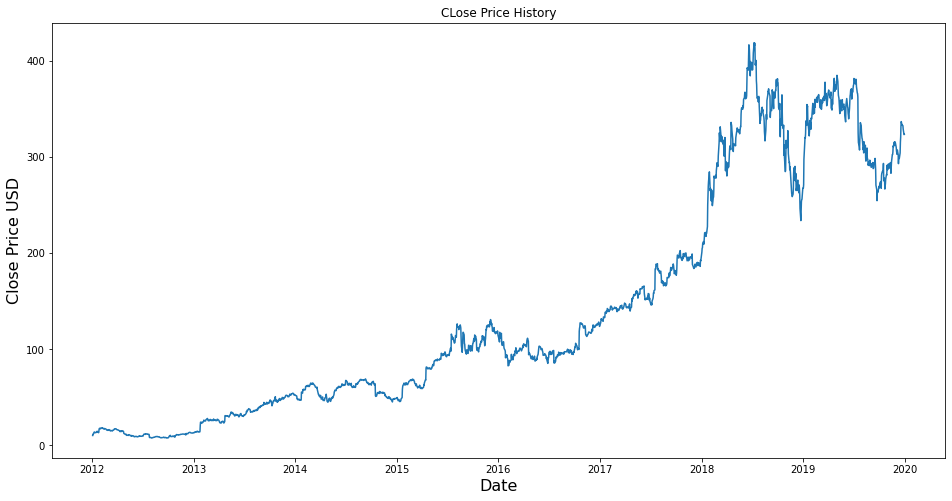

1550/1550 [==============================] - 49s 30ms/step - loss: 0.0011
ERROR rmse =  13.745438115513739


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


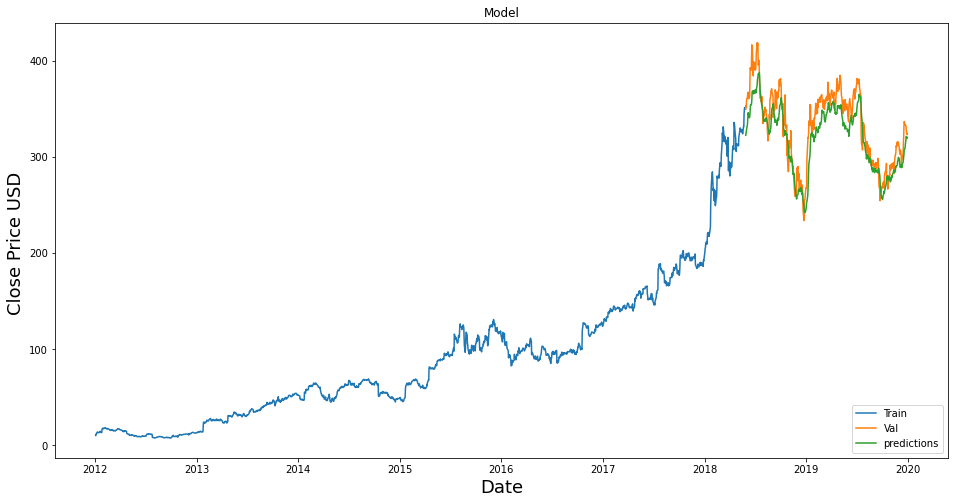

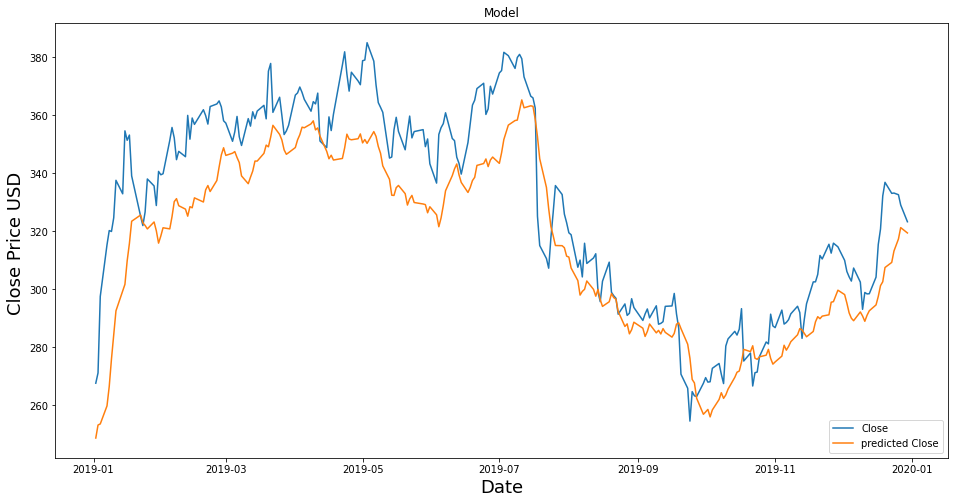

Starting Portfolio Value: 100000.00
2019-01-02, Close, 267.66
2019-01-02, BUY CREATE, 267.66
2019-01-03, BUY EXECUTED, Price: 253.24, Cost: 2532.42, Comm 0.00
2019-01-03, Close, 271.20
2019-01-03, BUY CREATE, 271.20
2019-01-04, BUY EXECUTED, Price: 253.61, Cost: 2536.15, Comm 0.00
2019-01-04, Close, 297.57
2019-01-04, BUY CREATE, 297.57
2019-01-07, BUY EXECUTED, Price: 259.83, Cost: 2598.27, Comm 0.00
2019-01-07, Close, 315.34
2019-01-07, BUY CREATE, 315.34
2019-01-08, BUY EXECUTED, Price: 266.54, Cost: 2665.42, Comm 0.00
2019-01-08, Close, 320.27
2019-01-08, BUY CREATE, 320.27
2019-01-09, BUY EXECUTED, Price: 276.01, Cost: 2760.08, Comm 0.00
2019-01-09, Close, 319.96
2019-01-09, BUY CREATE, 319.96
2019-01-10, BUY EXECUTED, Price: 284.15, Cost: 2841.49, Comm 0.00
2019-01-10, Close, 324.66
2019-01-10, BUY CREATE, 324.66
2019-01-11, BUY EXECUTED, Price: 292.60, Cost: 2926.04, Comm 0.00
2019-01-11, Close, 337.59
2019-01-11, BUY CREATE, 337.59
2019-01-14, BUY EXECUTED, Price: 299.42, Cost:

In [ ]:
stockName = 'NFLX'
netflix = trainingTheModel(path, stockName)
netflix.plotCloseVsDate()
netflix.splittingData()
netflix.modelArchitecture()
netflix.testModel()
netflix.visualizeTheTest()
predicted_df = netflix.simulateFuture60Days()
netflix.visualizeTestVsActual()
portofolio(netflix.df_predicted)

# Future Work: 

- Modifying the model somehow to be trained online. 
- Using different advanced trading algorithms. 
- Using Berts instead of Glove to take context dependence into consideration

# References: 
- Data Link:  https://unisydneyedu-my.sharepoint.com/personal/mjag7682_uni_sydney_edu_au/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fmjag7682%5Funi%5Fsydney%5Fedu%5Fau%2FDocuments%2FUni%5FStudy%5FMaterial%2Fdataset%2FLabelled%20Datatset%2D002%2Ezip&parent=%2Fpersonal%2Fmjag7682%5Funi%5Fsydney%5Fedu%5Fau%2FDocuments%2FUni%5FStudy%5FMaterial%2Fdataset&ga=1
- WE implemented the LSTM model on my own, but we took inspirations from the link below. 
  - https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/
- It was our Greeddy algorithm idea.
However, we took some references for our guidelines: 
  - https://github.com/mjag7682/NLP-of-StockTwits-data-for-predicting-stocks
  - Link of the website we scraped from 
    - https://stocktwits.com/   (tweets)
    - https://finance.yahoo.com/ (close price)


